In [ ]:
a=[1,1,1,1,4,4,5,5,5,5]
b=[1,1.1,1.2,1.3,4,4.1,4.7,4.8,4.9,5]

print()

In [1]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("ConceptualSpaces-master\\conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.concept import Concept
import matplotlib.pyplot as plt
import visualization.concept_inspector as ci



path = "Thesis\\Datasets\\Dual-PECCS\\s1s2_deploy_test\\files\\knowledge_base\\prototypes\\prototypes.xml"
path2 = "Thesis\\Datasets\\Dual-PECCS\\s1s2_deploy_test\\files\\knowledge_base\\exemplars\\exemplars.xml"


def print_database(node,indent=''):
    print(indent,node.tag,end=' ')
    try:
        print(node.attrib['name'],end=' ')
    except KeyError:
        pass
    if len(node):
        print()
        for subelem in node:
            print_database(subelem,indent+"  ")
    else:
        print(node.text)
    
def get_domains(xml_elem):
    domains = xml_elem.find('genericPhysicalDescription')
    if(not(domains)):
        return
    domain_dict={}
    try:
        domain_dict['supercategory']=xml_elem.find('family').text
    except AttributeError:
        domain_dict['supercategory']="object"
        
    for domain in domains:
        numerical_domain={}
        for subelem in domain:
            try:
                numerical_domain[subelem.tag]=float(subelem.text)
            except ValueError:
                pass
        if numerical_domain:
            domain_name=domain.tag
            if(domain_name=='hasPart' or domain_name=='partOf'):
                pass
                '''domain_name = domain.get('name')
                domain_dict['n_'+domain_name]={'number_'+domain_name:value for key,value in zip(numerical_domain.keys(),numerical_domain.values())}'''
            else:
                domain_dict[domain_name]={key:value for key,value in zip(numerical_domain.keys(),numerical_domain.values())}
    return domain_dict

def xml_to_dict(path, exemplars = {}):
    tree = ET.parse(os.path.normpath(path))
    root = tree.getroot()
    for exemplar in root:
        #print(animal.attrib['name'])
        new_concept = get_domains(exemplar)
        if(new_concept):
            exemplars[exemplar.attrib['name']] = new_concept
    return exemplars

    
def concepts_into_space(concepts, domains={}):
    colors=iter(['blue','green','brown','cyan','m'])
    concept_colors={}
    if(domains=={}):
        for concept in concepts.values():
            domains.update(concept)
        del(domains['supercategory'])
    #domains = mapping: domain->dimension indices
    domain_mapping = {}
    i=0
    for key in domains:
        domain_mapping[key]=list(range(i,i+len(domains[key])))
        i+=len(domains[key])

    dimension_names = []
    for domain in domains.values():
        dimension_names += [dim for dim in domain.keys()]
    space.init(len(dimension_names),domain_mapping,dimension_names)
    
    
    for example in concepts:
        if concepts[example]['supercategory'] in ['mammal','reptile','bird','amphibian','insect']:
            consistent = True
            domains = {}
            for key in concepts[example]:
                if(not(key=='supercategory')):
                    domains[key]=space._domains[key]

            '''dimension_names = []

            for concept_domain in concepts[example].values():
                dimension_names += [dim for dim in domain.keys()]'''

            dimension_values=[]
            for domain in space._domains.keys():
                dimension_values.append([list(concepts[example].get(domain,{str(key):float("-inf") for key in range(len(space._domains[domain]))}).values())
                                     ,list(concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values())])
                if(not(len(dimension_values[-1][0])==len(space._domains[domain]))):
                    #print(domain+' in '+example+' is inconsistent')
                    consistent=False
                    break
                if(not(consistent)):
                    print('bah')


            if(consistent):
                p_min=[value for domain in dimension_values for value in domain[0]]
                p_max=[value for domain in dimension_values for value in domain[1]]

                #try:
                c_example = Cuboid(p_min, p_max, domains)
                s_example = Core([c_example], domains)
                w_example = Weights(space._def_dom_weights,space._def_dim_weights)
                concept = Concept(s_example, 1.0, 0.5, w_example)

                supercategory = concepts[example]['supercategory']
                if(supercategory in space._concepts):
                    space.add_concept(supercategory, space._concepts[supercategory].union_with(concept), concept_colors[supercategory])
                else:
                    concept_colors.update({supercategory:next(colors)})
                    space.add_concept(supercategory, concept, concept_colors[supercategory])
                #print('added ', example)
                #print(concepts[example]['supercategory'])
        #except Exception:
        #    print(example,'is inconsistent')
''

''

[[[8.0, 0.5], [8.0, 0.5]], [[70.0, 30.0, 600.0, 80.0], [70.0, 30.0, 600.0, 80.0]], [[3.0, 1.0], [3.0, 1.0]], [[6.0, 3.0, 0.5], [6.0, 3.0, 0.5]], [[97.0, -22.0, 94.0], [97.0, -22.0, 94.0]]]
{'size': [8, 9, 10], 'color': [11, 12, 13], 'location': [2, 3, 4, 5], 'feeding': [6, 7], 'locomotion': [0, 1]}
mammal
0.011812740439499259
bird
7.831821935168409e-06
reptile
2.46566815655053e-14
amphibian
1.7702909846423717e-15
insect
1.0
butterfly
1.0
mammal
bird
reptile
amphibian
insect
butterfly


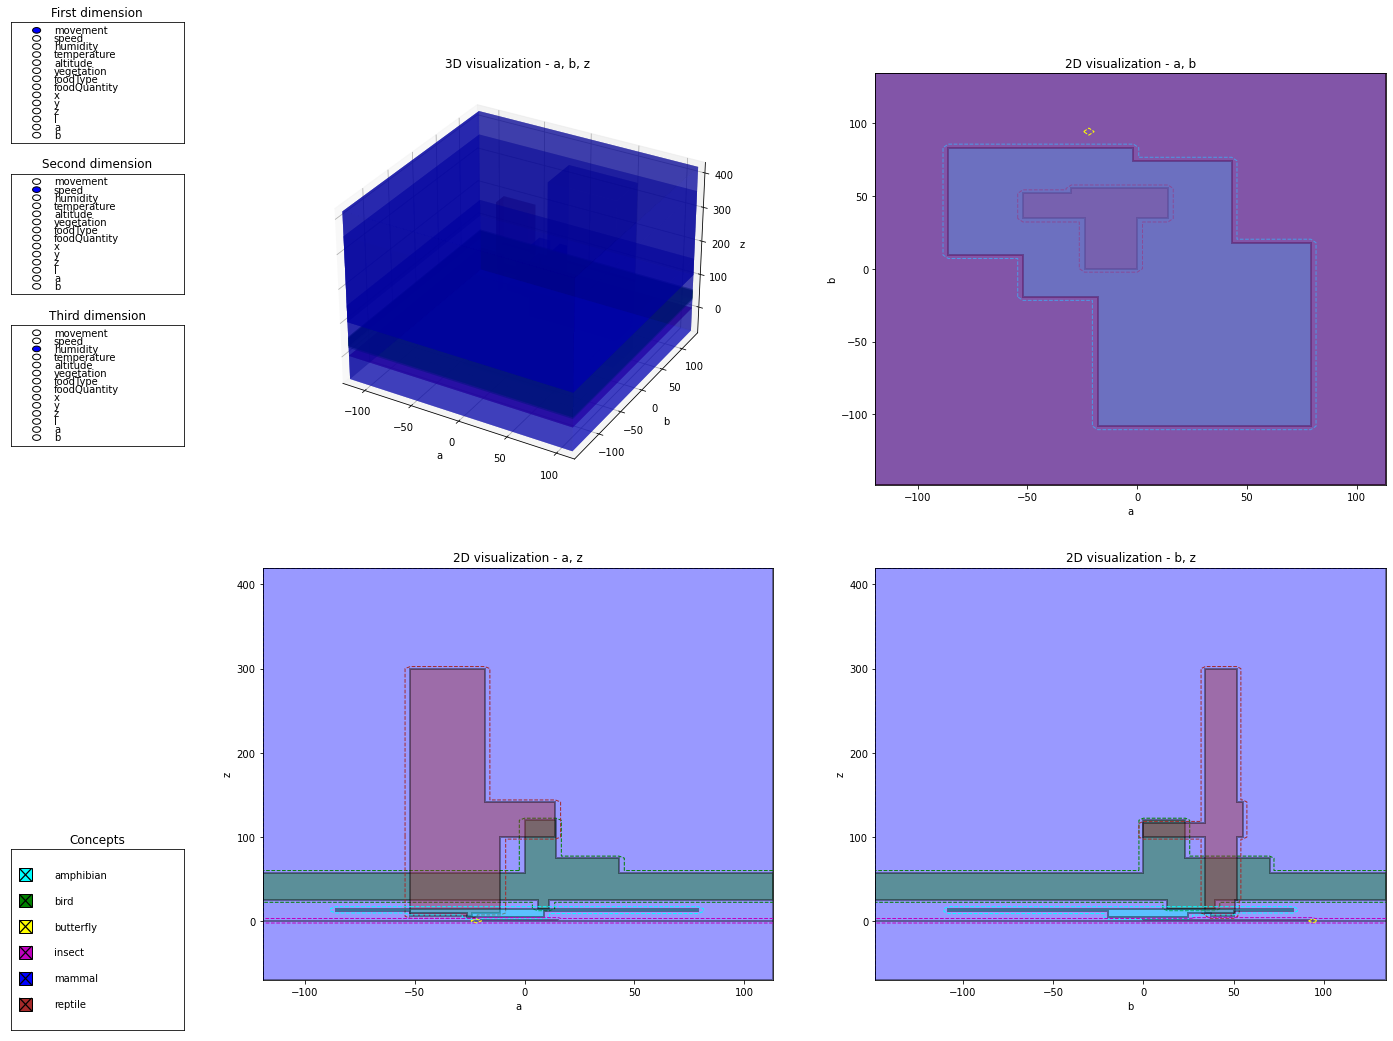

In [2]:
#%matplotlib widget
concepts = xml_to_dict(path)
concepts = xml_to_dict(path2, concepts)

domains = {}

for concept in concepts.values():
    domains.update(concept)
del(domains['supercategory'])


example='butterfly'
        
bear={example:concepts[example]}
del(concepts[example])
concepts_into_space(concepts)

dimension_values=[]
concepts=bear
consistent = True
#print(bear)
for domain in space._domains.keys():
    dimension_values.append([list(concepts[example].get(domain,{str(key):float("-inf") for key in range(len(space._domains[domain]))}).values())
                         ,list(concepts[example].get(domain,{str(key):float("inf") for key in range(len(space._domains[domain]))}).values())])
    if(not(len(dimension_values[-1][0])==len(space._domains[domain]))):
        print(domain+' in '+example+' is inconsistent')
        consistent=False
        break

domains = {}
for key in concepts[example]:
    if(not(key=='supercategory')):
        domains[key]=space._domains[key]

print(dimension_values)
print(domains)

if(consistent):
        p_min=[value for domain in dimension_values for value in domain[0]]
        p_max=[value for domain in dimension_values for value in domain[1]]

        #try:
        c_example = Cuboid(p_min, p_max, domains)
        s_example = Core([c_example], domains)
        w_example = Weights(space._def_dom_weights,space._def_dim_weights)
        bear = Concept(s_example, 1.0, 0.5, w_example)
        space.add_concept(example, bear, 'yellow')

        for concept in space._concepts:
            print(concept)
            #print(space._concepts[concept].membership_of([p if not p==float('-inf') else 0 for p in p_min]))
            print(space._concepts[concept].membership_of(p_max))
            #print(bear.subset_of(space._concepts[concept]))
ci.init(dims=[12,13,10])

In [3]:
plt.show()

In [3]:
bird
c1:  4.0  -  4.0  c2:  6.0  -  8.0 

c1:  10.0  -  10.0  c2:  16.875  -  25.66801525297619 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  -inf  -  inf  c2:  -inf  -  inf 

c1:  150.0  -  150.0  c2:  29.981498794987566  -  60.0 

c1:  250.0  -  250.0  c2:  55.51736111111111  -  100.0 

c1:  100.0  -  100.0  c2:  51.063169963987825  -  120.0 

c1:  30.0  -  30.0  c2:  42.45482653423327  -  100.0 

c1:  10.0  -  10.0  c2:  0.0  -  14.333333333333334 

c1:  40.0  -  40.0  c2:  0.0  -  23.333333333333332 

[  5.          13.4375     105.         175.         100.
  36.22741327  10.          31.66666667]
Singular matrix C in LSQ subproblem
0.0

bla
blu


In [3]:
a=float('inf')-float('inf')
a

nan

In [9]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("ConceptualSpaces-pure\\conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.concept import Concept
import visualization.concept_inspector as ci


domains = {"color":[0], "shape":[1]}
dimension_names = ["hue", "round"]
space.init(2, domains, dimension_names)



# standard weights for the dimensions within each domain
w_dim = {"color":{0:1}, "shape":{1:1}}

# define pear concept
c_pear = Cuboid([0.5, 0.4], [0.7, 0.6], domains)
s_pear = Core([c_pear], domains)
w_pear = Weights({"color":1.0, "shape":1.0}, w_dim)
pear = Concept(s_pear, 1.0, 24.0, w_pear)
space.add_concept("pear", pear, 'g')

#del(domains['taste'])

# define orange concept
c_orange = Cuboid([0.8, 0.7], [0.9, 0.8], domains)
s_orange = Core([c_orange], domains)
w_orange = Weights({"color":1.0, "shape":1.0}, w_dim)
orange = Concept(s_orange, 1.0, 24.0, w_orange)
space.add_concept("orange", orange, 'orange')

print(orange.subset_of(pear))

#ci.init()

0.09071795330000001


In [3]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("ConceptualSpaces-pure\\conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.concept import Concept
import visualization.concept_inspector as ci


domains = {"locomotion": [0], "bla": [1]}
dimension_names = ["movement", "speed"]
space.init(2, domains, dimension_names)

inf = float('inf')

# standard weights for the dimensions within each domain
w_dim = {"locomotion":{0:1}, "bla":{1:1}}


# define pear concept
c_pear = Cuboid([0.4, 0.1], [0.5, 0.11], domains)
s_pear = Core([c_pear], domains)
w_pear = Weights({"locomotion": 1.0, "bla": 1.0}, w_dim)
pear = Concept(s_pear, 1.0, 24.0, w_pear)
space.add_concept("pear", pear, 'g')


# define orange concept
c_orange = Cuboid([0.6, 4.0], [0.8, 20.0], domains)
s_orange = Core([c_orange], domains)
w_orange = Weights({'locomotion': 1.0, 'bla': 1.0}, w_dim)
orange = Concept(s_orange, 1.0, 24.0, w_orange)
space.add_concept("orange", orange, 'orange')

print(orange.subset_of(pear))

#ci.init()

Singular matrix C in LSQ subproblem


Exception: Optimizer failed!

In [ ]:
import xml.etree.ElementTree as ET
import os
import sys
sys.path.append("ConceptualSpaces-pure\\conceptual_spaces")
import cs.cs as space
from cs.weights import Weights
from cs.cuboid import Cuboid
from cs.core import Core
from cs.concept import Concept
import visualization.concept_inspector as ci


domains = {'locomotion': [0, 1], 'location': [2, 3, 4, 5], 'feeding': [6, 7], 'size': [8, 9, 10], 'color': [11, 12, 13]}
dimension_names = ['movement', 'speed', 'humidity', 'temperature', 'altitude', 'vegetation', 'foodType', 'foodQuantity', 'x', 'y', 'z', 'l', 'a', 'b']
space.init(14, domains, dimension_names)

inf = float('inf')

# standard weights for the dimensions within each domain
w_dim = space._def_dim_weights
w_dom = space._def_dom_weights


domainsp=domains.copy()
del(domainsp['location'])
del(domainsp['feeding'])
# define pear concept
c_pear = Cuboid([4.0, 10.0, -inf, -inf, -inf, -inf, -inf, -inf, 150.0, 250.0, 100.0, 30.0, 10.0, 40.0], [4.0, 10.0, inf, inf, inf, inf, inf, inf, 150.0, 250.0, 100.0, 30.0, 10.0, 40.0], domainsp)
s_pear = Core([c_pear], domainsp)
w_pear = Weights(w_dom, w_dim)
pear = Concept(s_pear, 1.0, 24.0, w_pear)
space.add_concept("pear", pear, 'g')


# define orange concept
c_orange = Cuboid([6.0, 16.875, -inf, -inf, -inf, -inf, -inf, -inf, 29.981498794987566, 55.51736111111111, 51.063169963987825, 42.45482653423327, 0.0, 0.0], [8.0, 25.66801525297619, inf, inf, inf, inf, inf, inf, 60.0, 100.0, 120.0, 100.0, 14.333333333333334, 23.333333333333332], domainsp)
s_orange = Core([c_orange], domainsp)
w_orange = Weights(w_dom, w_dim)
orange = Concept(s_orange, 1.0, 30.0, w_orange)
space.add_concept("orange", orange, 'orange')

print(orange.subset_of(pear))

ci.init()